In [10]:
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState, Clock
from collections import namedtuple, defaultdict, Counter
import datetime
from dateutil.parser import parse
import glob
import csv
import itertools
from __future__ import print_function
import random
import numpy as np
import pandas as pd
import csv
from pprint import pprint

Person = namedtuple('Person', 'gender age spent')


In [11]:
def get_amount():
    return round(max([1, 30  + 5 * np.random.randn()]), 2)

def make_data(num=10):
    adult_ages = range(18, 80)
    child_ages = range(10, 18)
    genders = ['female', 'male'] * 10
    get_age_for = {
        'child': lambda: random.choice(child_ages),
        'adult': lambda: random.choice(adult_ages)
    }
    rec_list = []
    for nn in range(num):
        gender = random.choice(genders)
        age = get_age_for[random.choice(['adult', 'child'])]()
        spent = get_amount()
        rec_list.append((gender, age, spent))
    df = pd.DataFrame(rec_list, columns=['gender', 'age', 'spent'])
    return df

df = make_data()
df.to_csv('age_gender.csv', index=False)
print(df.head().to_csv(index=False))
    

gender,age,spent
male,49,22.46
male,55,33.08
male,12,36.76
male,65,29.68
male,17,34.17



* Maybe before the example, talk about wiring factoring between nodes and wiring.
* Talk about filtering, aggregating, and grouping with nodes.  Grouping can just push an iterator.
* Talk about wiring nodes together with routing and broadcasting
* Talk about when begin, end, process are executed.


# Simple Pipeline For Find Total Spending

* A pipeline consists of nodes that are wired together
* Every node must have a .process() method that is called once for each item it consumes
* Nodes can have optional .begin() and .end() methods for setting up and tearing down local state
* A call to .push() can be made anywhere inside .process() or .end() methods.  Calling .push(item)
  will push item to any/all connected downstream node(s).
* Pipelines are constructed by wiring nodes together with syntax inspired by unix pipes.


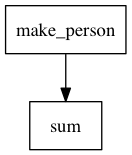

sum total was 318.41


In [12]:
# Node to extract namedtuple from csv row
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))

# Node to sum all values that pass through it
class Sum(Node):
    def begin(self):
        self.total = 0
    
    def process(self, item):
        self.total += item.spent
        self.push(item)
        
    def end(self):
        print('{} total was {}'.format(self.name, self.total))
        
# Wire nodes into pipeline with bash inspired syntax            
pipe = Pipeline(
    MakePerson('make_person') | Sum('sum') 
)

# create pipeline visualization
pipe.plot(display_notebook=True)

# process the csv file
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

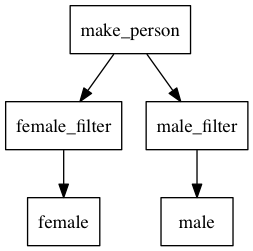

male total was 156.15
female total was 162.26


In [13]:
# define a gender-based route function
def by_gender(item):
    return '{}'.format(item.gender)

class Filter(Node):
    def process(self, item):
        if item.gender == self.gender:
            self.push(item)
    
    
# Wire nodes together            
pipe = Pipeline(
    MakePerson('make_person') | [
        Filter('male_filter', gender='male') | Sum('male'),
        Filter('female_filter', gender='female') | Sum('female')
    ] 
)

# visualize pipeline
pipe.plot(display_notebook=True)

# process csv file
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

# Add Routing To Aggregate By Gender

* Broadcasting is done by piping to a list of nodes
* Routing is done by piping to a list of one function and multiple nodes.  The function must return the name of one of   the nodes in the list.  Incoming items will be send to the node named by the routing function.

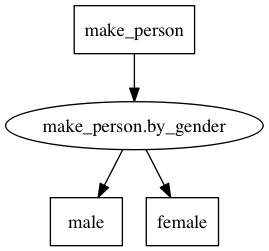

male total was 156.15
female total was 162.26


In [14]:
# define a gender-based route function
def by_gender(item):
    return '{}'.format(item.gender)
    
# Wire nodes together            
pipe = Pipeline(
    MakePerson('make_person') | [Sum('male'), Sum('female'), by_gender] 
)

# visualize pipeline
pipe.plot(display_notebook=True)

# process csv file
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

# Add Routing to Aggregate By Gender and Age
* Very easy to build trees by piping to nested lists in your pipeline definition
  - `make_person` routes to two nodes, each of which routes to two additional nodes

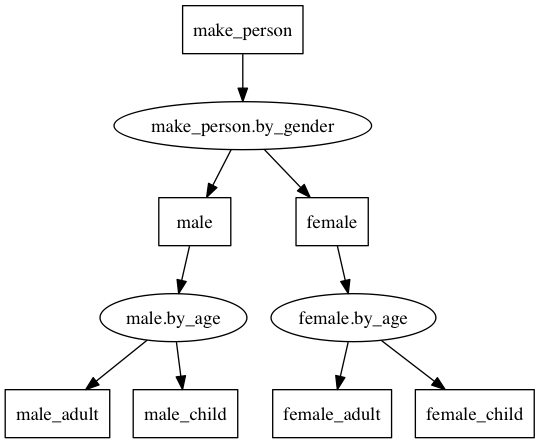

male total was 156.15
male_child total was 70.93
male_adult total was 85.22
female total was 162.26
female_child total was 100.16
female_adult total was 62.1


In [15]:
# define an age-based route function
def by_age(item):
    if item.age >= 18:
        return '{}_adult'.format(item.gender)
    else:
        return '{}_child'.format(item.gender)
    
# wire nodes together
pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (Sum('male') | [Sum('male_child'), Sum('male_adult'), by_age]),
        (Sum('female') | [Sum('female_child'), Sum('female_adult'), by_age]),
        by_gender
    ]
)

# visualize the pipeline
pipe.plot(display_notebook=True)

# process the csv file
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

# Combining Node Outputs to Form Directed Graph
* Sometimes the unix-like abstraction for building pipelines is not expressive enough to make the topology you want.
  In this case, nodes can be explicitely wired together using their `.add_downstream()` methods

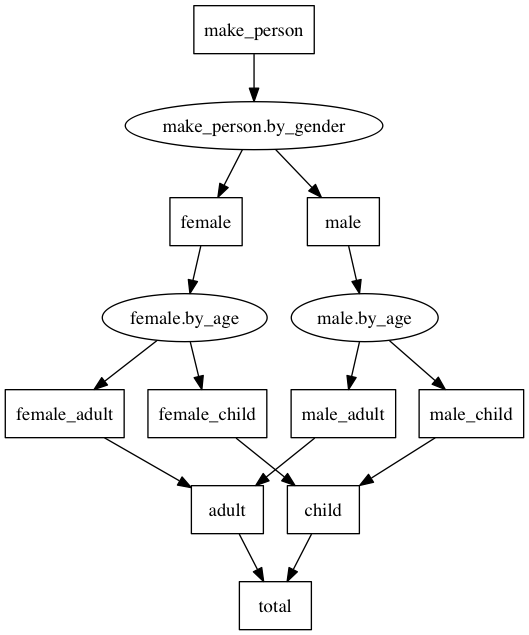

male total was 156.15
male_child total was 70.93
male_adult total was 85.22
female total was 162.26
female_child total was 100.16
child total was 171.09
female_adult total was 62.1
adult total was 147.32
total total was 318.41


In [16]:
# create a more advanced pipeline
pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (Sum('male') | [Sum('male_child'), Sum('male_adult'), by_age]),
        (Sum('female') | [Sum('female_child'), Sum('female_adult'), by_age]),
        by_gender
    ]
)

# create additional nodes    
adult = Sum('adult')
child = Sum('child')
total = Sum('total')

# explicitely connect extra nodes
adult.add_downstream(total)
child.add_downstream(total)

# pipeline nodes can be accessed with dict-like syntax
pipe['male_child'].add_downstream(child)
pipe['female_child'].add_downstream(child)
pipe['male_adult'].add_downstream(adult)
pipe['female_adult'].add_downstream(adult)

# visualize pipeline
pipe.plot(display_notebook=True)

# process csv file
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

# Accessing Global State
* Nodes manage their local state by setting and mutating attributes on the Node class
* Sometimes you want state that is accessible to the entire pipeline.  This is available
  using the `global_state` attribute on each node.
* Global state is accessible and mutable to every node in the pipeline and can be accessed
  through the `.global_state` attribute on the pipeline after processing is complete.
* Consecution forces you to be explicit about how what state you are mutating.  It can either
  be confined to the `.process()` method, confined to the node, or available to the whole
  pipeline.

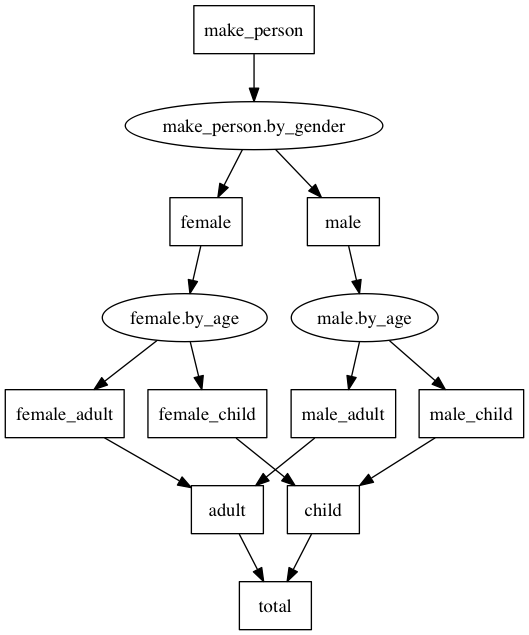

male total was 156.15
male_child total was 70.93
male_adult total was 85.22
female total was 162.26
female_child total was 100.16
child total was 171.09
female_adult total was 62.1
adult total was 147.32
total total was 318.41

{'adult': 147.32,
 'child': 171.09,
 'female': 162.26,
 'female_adult': 62.1,
 'female_child': 100.16,
 'male': 156.14999999999998,
 'male_adult': 85.22,
 'male_child': 70.93,
 'total': 318.40999999999997}


In [18]:
# Make a new kind of summing node that mutates global state
class GSum(Sum):
    def end(self):
        super(GSum, self).end()
        self.global_state.segment_totals[self.name] = self.total


pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (GSum('male') | [GSum('male_child'), GSum('male_adult'), by_age]),
        (GSum('female') | [GSum('female_child'), GSum('female_adult'), by_age]),
        by_gender
    ],
    global_state=GlobalState(segment_totals={})
)

# create and explicitly wire together extra nodes
adult = GSum('adult')
child = GSum('child')
total = GSum('total')
adult.add_downstream(total)
child.add_downstream(total)

# plug new nodes into the pipeline
pipe['male_child'].add_downstream(child)
pipe['female_child'].add_downstream(child)
pipe['male_adult'].add_downstream(adult)
pipe['female_adult'].add_downstream(adult)

# visualize pipeline
pipe.plot(display_notebook=True)

# process csv
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))
    
# access summary information
print()
pprint(pipe.global_state.segment_totals)

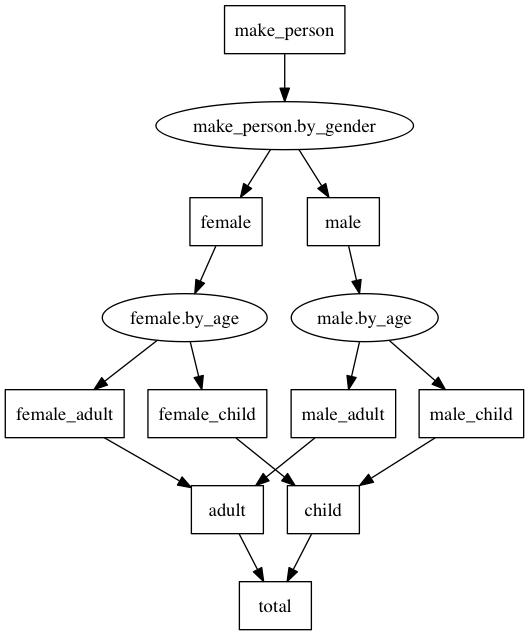

male total was 156.15
male_child total was 70.93
male_adult total was 85.22
female total was 162.26
female_child total was 100.16
child total was 171.09
female_adult total was 62.1
adult total was 147.32
total total was 318.41

{'adult': 147.32,
 'child': 171.09,
 'female': 162.26,
 'female_adult': 62.1,
 'female_child': 100.16,
 'male': 156.14999999999998,
 'male_adult': 85.22,
 'male_child': 70.93,
 'total': 318.40999999999997}


In [19]:
def pipe_factory(SumClass):

    def by_age(item):
        if item.age >= 18:
            return '{}_adult'.format(item.gender)
        else:
            return '{}_child'.format(item.gender)

    def by_gender(item):
        return '{}'.format(item.gender)


    pipe = Pipeline(
        MakePerson('make_person') | 
        [
            (SumClass('male') | [SumClass('male_child'), SumClass('male_adult'), by_age]),
            (SumClass('female') | [SumClass('female_child'), SumClass('female_adult'), by_age]),
            by_gender
        ],
        global_state=GlobalState(segment_totals={})
    )

    # create and explicitly wire together extra nodes
    adult = SumClass('adult')
    child = SumClass('child')
    total = SumClass('total')
    adult.add_downstream(total)
    child.add_downstream(total)

    # plug new nodes into the pipeline
    pipe['male_child'].add_downstream(child)
    pipe['female_child'].add_downstream(child)
    pipe['male_adult'].add_downstream(adult)
    pipe['female_adult'].add_downstream(adult)

    # visualize pipeline
    pipe.plot(display_notebook=True)
    return pipe

pipe = pipe_factory(GSum)

# process csv
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

# access summary information
print()
pprint(pipe.global_state.segment_totals)

In [ ]:
pipe.plot()